# Deep Convolutional GANs

Brief introduction to Deep Convolutional Generative Adversarial Networks or DCGANs. This notebook is organized as follows:

1. **Research Paper**
1. **Background**
2. **Definition**
3. **Training DCGANs with CIFAR-10 dataset, Keras and TensorFlow**

---

## 1. Research Paper

* [Unsupervised Representation Learning With Deep Convolutional](https://arxiv.org/pdf/1511.06434.pdf)

## 2. Background

Brief definition of some concepts, such as convolution and Convolutional Neural Network (CNN) and GANs.

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

![convolution](https://devblogs.nvidia.com/wp-content/uploads/2015/11/convolution.png)

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **cost function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.

DCGAN are mainly composes of convolution layers without max pooling or fully connected layers. It uses convolutional stride and transposed convolution for the downsampling and the upsampling. 

### Network Design

<img src="../../img/network_design_dcgan.png" width="600"> 


### Cost Funcion


$$ \underset{G}{min} \: \underset{D}{max} \; V_{DCGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

> * Replace all max pooling with convolutional stride.
    Use transposed convolution for upsampling.
    Eliminate fully connected layers.
    Use Batch normalization except the output layer for the generator and the input layer of the discriminator.
    Use ReLU in the generator except for the output which uses tanh.
    Use LeakyReLU in the discriminator.*



## 4. Training DCGANs with CIFAR-10 dataset, Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the CIFAR-10 images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * Use the **Convolutional neural network**.
    * **LeakyReLU activation** and **BatchNormalization**.
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0003, beta_1=0.5)

* batch_size = 64
* epochs = 100


### 1. Load data

#### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


2023-11-07 12:16:23.469185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 12:16:23.501175: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Getting the data

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()


#### Explore visual data

The CIFAR-10 images are RGB with 10 classes

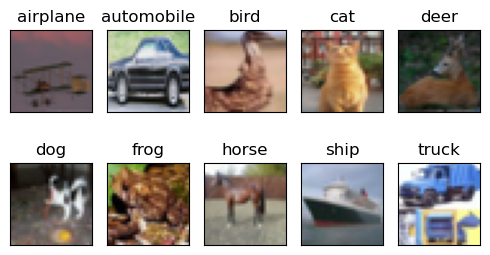

In [3]:
WIDTH_SIZE = 5
HEIGHT_SIZE = 3

num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()


#### Reshaping and normalizing the inputs

In [4]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')


X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)


X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


### 2. Define model

#### Generator

In [6]:
# latent space dimension
latent_dim = 100

# Generator network
generator = tf.keras.models.Sequential()

generator.add(
    tf.keras.layers.Dense(
        4 * 4 * 256, use_bias=False, input_shape=(latent_dim,)
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())
generator.add(tf.keras.layers.Reshape((4, 4, 256)))

generator.add(
    tf.keras.layers.Conv2DTranspose(
        128, kernel_size=5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        64, kernel_size=5, strides=2, padding="same", use_bias=False
    )
)
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

generator.add(
    tf.keras.layers.Conv2DTranspose(
        3,
        kernel_size=5,
        strides=2,
        padding="same",
        use_bias=False,
        activation="tanh",
    )
)


2023-11-07 12:16:25.046318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 12:16:25.060882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 12:16:25.060994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 12:16:25.061809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              409600    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

#### Discriminator


In [8]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = tf.keras.models.Sequential()

discriminator.add(
    tf.keras.layers.Conv2D(
        64, kernel_size=5, strides=2, padding="same", input_shape=(img_shape)
    )
)
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same")
)
discriminator.add(tf.keras.layers.LeakyReLU(0.2))
discriminator.add(tf.keras.layers.Dropout(0.3))

discriminator.add(tf.keras.layers.Flatten())

discriminator.add(tf.keras.layers.Dense(1, activation="sigmoid"))


#### Discriminator model visualization

In [9]:
# prints a summary representation of your model
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

### 3. Compile model

#### Compile discriminator

In [10]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)



#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [11]:
discriminator.trainable = False

z = tf.keras.layers.Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = tf.keras.models.Model(inputs=z, outputs=decision)

d_g.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)


#### GAN model vizualization

In [12]:
# prints a summary representation of your model
d_g.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         1455552   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 217985    
                                                                 
Total params: 1,673,537
Trainable params: 1,446,976
Non-trainable params: 226,561
_________________________________________________________________


### 4. Fit model


2023-11-07 12:16:25.550007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2023-11-07 12:16:25.603937: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 12:16:25.604410: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 12:16:25.604417: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-11-07 12:16:25.604873: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-07 12:16:25.604895: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-07 12:16:25.681612: I tensorflow/stream_executor/cuda/c

epoch = 1/100, d_loss=0.689, g_loss=1.071                                                                                                                        
1/1 [==============================] - 0s 126ms/step


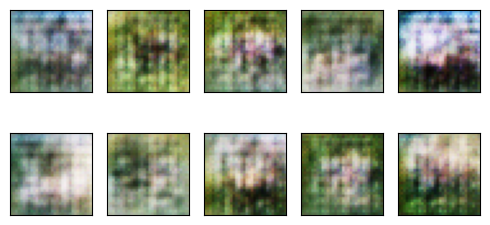

epoch = 2/100, d_loss=0.614, g_loss=1.720                                                                                                                        
epoch = 3/100, d_loss=0.556, g_loss=1.168                                                                                                                        
epoch = 4/100, d_loss=0.560, g_loss=1.363                                                                                                                        
epoch = 5/100, d_loss=0.488, g_loss=1.180                                                                                                                        
epoch = 6/100, d_loss=0.526, g_loss=1.588                                                                                                                        
epoch = 7/100, d_loss=0.512, g_loss=1.191                                                                                                                        
epoch = 8/100, d_loss=0.431,

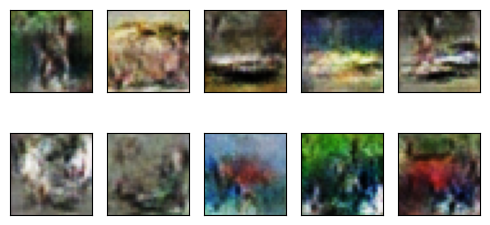

epoch = 12/100, d_loss=0.541, g_loss=1.196                                                                                                                        
epoch = 13/100, d_loss=0.599, g_loss=1.396                                                                                                                        
epoch = 14/100, d_loss=0.576, g_loss=1.324                                                                                                                        
epoch = 15/100, d_loss=0.597, g_loss=1.192                                                                                                                        
epoch = 16/100, d_loss=0.607, g_loss=1.178                                                                                                                        
epoch = 17/100, d_loss=0.570, g_loss=1.213                                                                                                                        
epoch = 18/100, d_loss

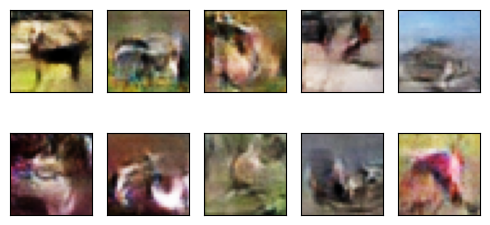

epoch = 22/100, d_loss=0.654, g_loss=1.123                                                                                                                        
epoch = 23/100, d_loss=0.662, g_loss=1.094                                                                                                                        
epoch = 24/100, d_loss=0.659, g_loss=1.025                                                                                                                        
epoch = 25/100, d_loss=0.679, g_loss=1.042                                                                                                                        
epoch = 26/100, d_loss=0.690, g_loss=1.103                                                                                                                        
epoch = 27/100, d_loss=0.636, g_loss=1.164                                                                                                                        
epoch = 28/100, d_loss

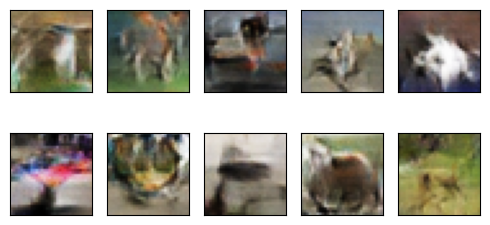

epoch = 32/100, d_loss=0.690, g_loss=1.007                                                                                                                        
epoch = 33/100, d_loss=0.721, g_loss=1.044                                                                                                                        
epoch = 34/100, d_loss=0.677, g_loss=0.961                                                                                                                        
epoch = 35/100, d_loss=0.664, g_loss=1.159                                                                                                                        
epoch = 36/100, d_loss=0.627, g_loss=1.081                                                                                                                        
epoch = 37/100, d_loss=0.641, g_loss=1.137                                                                                                                        
epoch = 38/100, d_loss

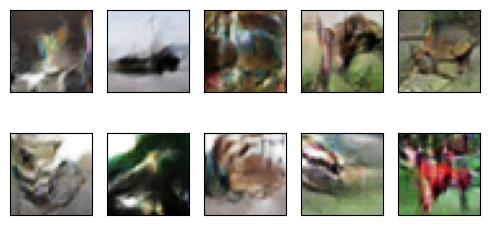

epoch = 42/100, d_loss=0.695, g_loss=0.904                                                                                                                        
epoch = 43/100, d_loss=0.665, g_loss=0.987                                                                                                                        
epoch = 44/100, d_loss=0.631, g_loss=1.142                                                                                                                        
epoch = 45/100, d_loss=0.613, g_loss=1.128                                                                                                                        
epoch = 46/100, d_loss=0.667, g_loss=1.185                                                                                                                        
epoch = 47/100, d_loss=0.610, g_loss=1.104                                                                                                                        
epoch = 48/100, d_loss

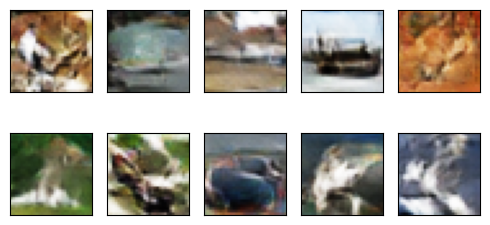

epoch = 52/100, d_loss=0.623, g_loss=0.959                                                                                                                        
epoch = 53/100, d_loss=0.626, g_loss=1.026                                                                                                                        
epoch = 54/100, d_loss=0.624, g_loss=1.100                                                                                                                        
epoch = 55/100, d_loss=0.658, g_loss=1.260                                                                                                                        
epoch = 56/100, d_loss=0.633, g_loss=1.170                                                                                                                        
epoch = 57/100, d_loss=0.600, g_loss=1.164                                                                                                                        
epoch = 58/100, d_loss

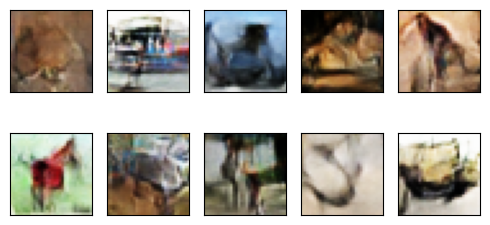

epoch = 62/100, d_loss=0.663, g_loss=1.153                                                                                                                        
epoch = 63/100, d_loss=0.628, g_loss=1.171                                                                                                                        
epoch = 64/100, d_loss=0.690, g_loss=1.228                                                                                                                        
epoch = 65/100, d_loss=0.647, g_loss=0.990                                                                                                                        
epoch = 66/100, d_loss=0.617, g_loss=1.127                                                                                                                        
epoch = 67/100, d_loss=0.635, g_loss=1.117                                                                                                                        
epoch = 68/100, d_loss

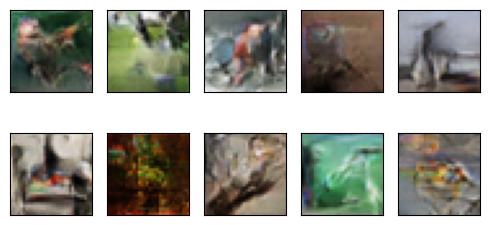

epoch = 72/100, d_loss=0.633, g_loss=1.255                                                                                                                        
epoch = 73/100, d_loss=0.676, g_loss=1.445                                                                                                                        
epoch = 74/100, d_loss=0.612, g_loss=1.312                                                                                                                        
epoch = 75/100, d_loss=0.641, g_loss=1.186                                                                                                                        
epoch = 76/100, d_loss=0.659, g_loss=1.025                                                                                                                        
epoch = 77/100, d_loss=0.673, g_loss=1.069                                                                                                                        
epoch = 78/100, d_loss

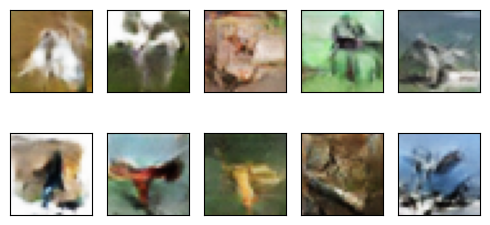

epoch = 82/100, d_loss=0.610, g_loss=1.169                                                                                                                        
epoch = 83/100, d_loss=0.702, g_loss=1.182                                                                                                                        
epoch = 84/100, d_loss=0.630, g_loss=1.103                                                                                                                        
epoch = 85/100, d_loss=0.649, g_loss=1.116                                                                                                                        
epoch = 86/100, d_loss=0.636, g_loss=1.068                                                                                                                        
epoch = 87/100, d_loss=0.644, g_loss=1.146                                                                                                                        
epoch = 88/100, d_loss

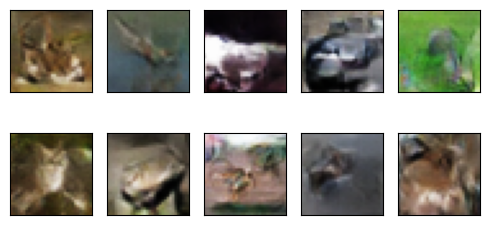

epoch = 92/100, d_loss=0.698, g_loss=1.076                                                                                                                        
epoch = 93/100, d_loss=0.671, g_loss=1.254                                                                                                                        
epoch = 94/100, d_loss=0.691, g_loss=1.208                                                                                                                        
epoch = 95/100, d_loss=0.660, g_loss=1.065                                                                                                                        
epoch = 96/100, d_loss=0.605, g_loss=1.286                                                                                                                        
epoch = 97/100, d_loss=0.644, g_loss=1.221                                                                                                                        
epoch = 98/100, d_loss

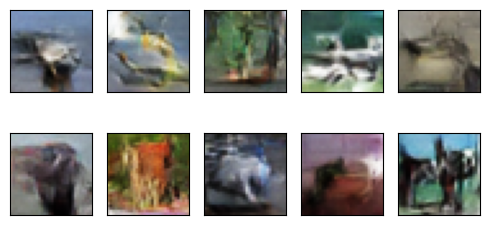

In [13]:
epochs = 100
batch_size = 32
smooth = 0.1

real = tf.ones(shape=(batch_size, 1))
fake = tf.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):

        # Train Discriminator weights
        discriminator.trainable = True

        # Real samples
        X_batch = X_train[i * batch_size : (i + 1) * batch_size]
        d_loss_real = discriminator.train_on_batch(
            x=X_batch, y=real * (1 - smooth)
        )

        # Fake Samples
        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)

        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

        # Train Generator weights
        discriminator.trainable = False

        z = tf.random.normal(shape=(batch_size, latent_dim), mean=0, stddev=1)
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            "epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f"
            % (
                e + 1,
                epochs,
                i,
                len(X_train) // batch_size,
                d_loss_batch,
                g_loss_batch[0],
            ),
            100 * " ",
            end="\r",
        )

    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])

    print(
        "epoch = %d/%d, d_loss=%.3f, g_loss=%.3f"
        % (e + 1, epochs, d_loss[-1], g_loss[-1]),
        100 * " ",
    )

    if e % 10 == 0:
        samples = 10

        z = tf.random.normal(shape=(samples, latent_dim), mean=0, stddev=1)
        x_fake = generator.predict(z)

        fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1) * 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()


### 5. Evaluate model

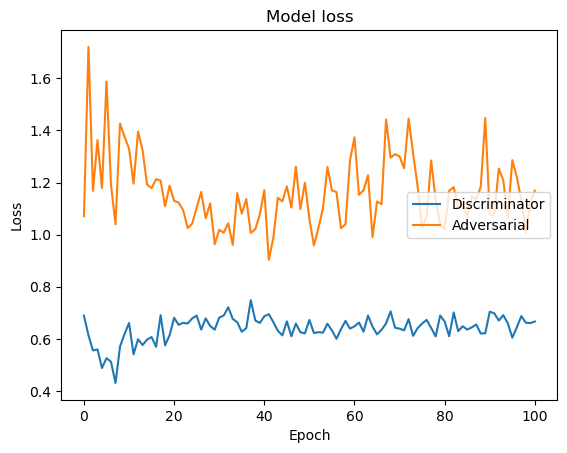

In [14]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()


## References

* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)
* [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)